In [8]:
import pandas as pd
import time
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score

In [9]:
def split(strt,fnsh,df):
    X_test = df['text'].iloc[strt:fnsh+1]
    y_test = df['label'].iloc[strt:fnsh+1].astype('int')
    df = df.drop(df.index[strt:fnsh])
    X_train = df['text']
    y_train = df['label'].astype('int')    
    return X_train, X_test, y_train, y_test

In [10]:
def classifier(df,distance_name,k_neighbor):
    print("Nama distance=",distance_name)
    print("Jumlah K tetangga=",k_neighbor)
    spl = [0,108,216,324,432,540,648,756,864,972,1080]
    tempspl,acc_score,pre_score,rec_score,f_score = [],[],[],[],[]
    i = 0
    akurasimax=0
    kf = KFold(n_splits=10)
    for train_index, test_index in kf.split(df):
        dfX = df
        X_train, X_test, y_train, y_test = split(test_index[0],test_index[len(test_index)-1],dfX)
#     while (i<len(spl)-1):
# #         --------------Split-------------------
#         if len(spl)-2 != len(tempspl):
#             X_train, X_test, y_train, y_test = split(spl[i],spl[i+2],df)
#             tempspl.append(spl[i])
#     #   ketika array[i+2] == null (looping terakhir)
#         elif (len(spl)-len(tempspl)) == 2:
#     #       split last and first
#             X_test1 = df['text'].iloc[spl[i]:spl[i+1]]
#             y_test1 = df['label'].iloc[spl[i]:spl[i+1]].astype('int')
#             X_test2 = df['text'].iloc[tempspl[0]:tempspl[1]]
#             y_test2 = df['label'].iloc[tempspl[0]:tempspl[1]].astype('int')
#     #       concat last and first
#             X_test = pd.concat([X_test1, X_test2], axis=0)
#             y_test = pd.concat([y_test1, y_test2], axis=0)
#     #       split except last and first
#             X_train = df['text'].iloc[tempspl[1]:tempspl[len(tempspl)-1]]
#             y_train = df['label'].iloc[tempspl[1]:tempspl[len(tempspl)-1]].astype('int')
        
#         --------------Pembobotan TF-ID-------------------
        vectorizer = TfidfVectorizer(min_df=3, dtype=np.double, norm='l2', sublinear_tf=True)
#         vectorizer = TfidfVectorizer()
        X_train = vectorizer.fit_transform(X_train)
        X_test = vectorizer.transform(X_test)

#         --------------CLasifier KNN-------------------        
        modelknn = KNeighborsClassifier(n_neighbors=k_neighbor, weights='distance', metric=distance_name)
#         modelknn = svm.SVC()
        modelknn.fit(X_train,y_train)
        y_pred = modelknn.predict(X_test)
#         print(classification_report(y_test,y_pred))
        akurasi = modelknn.score(X_test, y_test)
        precision = precision_score(y_test,y_pred,average='weighted', labels=np.unique(y_pred))
        recall = recall_score(y_test, y_pred, average='weighted')
        f1score = f1_score(y_test, y_pred, average='weighted', labels=np.unique(y_pred))
        acc_score.append(akurasi)
        pre_score.append(precision)
        rec_score.append(recall)
        f_score.append(f1score)
        print("Fold ke-",i+1,"Akurasi =","{:.4f}".format(akurasi),
              "Precision =","{:.4f}".format(precision),
              "Recall =","{:.4f}".format(recall),
              "F1-Score =","{:.4f}".format(f1score))
        if (akurasi >= akurasimax):
            akurasimax = akurasi
            foldke = i+1
        i+=1
    avg_acc_score = sum(acc_score)/10
    avg_precision_score = sum(pre_score)/10
    avg_recall_score = sum(rec_score)/10
    avg_f1_score = sum(f_score)/10
    print("Avg accuracy =","{:.4f}".format(avg_acc_score),
          "Avg precision=","{:.4f}".format(avg_precision_score),
          "Avg recall=","{:.4f}".format(avg_recall_score),
          "Avg f1 Score=","{:.4f}".format(avg_f1_score))
#     print('Avg accuracy : {}'.format(avg_acc_score))
    print("Akurasi terbaik adalah",akurasimax,"pada fold ke-",foldke)
    print("------------------------------------")
    return avg_acc_score

In [11]:
df = pd.read_pickle(r'D:\JupyterNotebook\DataProcess\preprocess_SWnltk_stemming.pkl')
dfNo = pd.read_pickle(r'D:\JupyterNotebook\DataProcess\preprocess_SWnltk_nostemming.pkl')

Dengan Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
Fold ke- 1 Akurasi = 0.1204 Precision = 0.6812 Recall = 0.1204 F1-Score = 0.1601
Fold ke- 2 Akurasi = 0.1481 Precision = 0.8699 Recall = 0.1481 F1-Score = 0.2182
Fold ke- 3 Akurasi = 0.5926 Precision = 0.6264 Recall = 0.5926 F1-Score = 0.5768
Fold ke- 4 Akurasi = 0.2037 Precision = 0.8773 Recall = 0.2037 F1-Score = 0.2718
Fold ke- 5 Akurasi = 0.2315 Precision = 0.8628 Recall = 0.2315 F1-Score = 0.3338
Fold ke- 6 Akurasi = 0.3056 Precision = 0.8884 Recall = 0.3056 F1-Score = 0.4829
Fold ke- 7 Akurasi = 0.2778 Precision = 0.8608 Recall = 0.2778 F1-Score = 0.3630
Fold ke- 8 Akurasi = 0.2130 Precision = 0.7666 Recall = 0.2130 F1-Score = 0.2445
Fold ke- 9 Akurasi = 0.2037 Precision = 0.7043 Recall = 0.2037 F1-Score = 0.3243
Fold ke- 10 Akurasi = 0.2130 Precision = 0.8039 Recall = 0.2130 F1-Score = 0.3174
Avg accuracy = 0.2509 Avg precision= 0.7942 Avg recall= 0.2509 Avg f1 Score= 0.3293
Akurasi terbaik adalah 0.5925925925925926 p

Fold ke- 1 Akurasi = 0.0926 Precision = 0.5421 Recall = 0.0926 F1-Score = 0.1776
Fold ke- 2 Akurasi = 0.1019 Precision = 0.6950 Recall = 0.1019 F1-Score = 0.1855
Fold ke- 3 Akurasi = 0.1574 Precision = 0.8862 Recall = 0.1574 F1-Score = 0.2161
Fold ke- 4 Akurasi = 0.1204 Precision = 0.8173 Recall = 0.1204 F1-Score = 0.1919
Fold ke- 5 Akurasi = 0.1667 Precision = 0.8485 Recall = 0.1667 F1-Score = 0.2990
Fold ke- 6 Akurasi = 0.2130 Precision = 0.8493 Recall = 0.2130 F1-Score = 0.3958
Fold ke- 7 Akurasi = 0.1944 Precision = 0.8246 Recall = 0.1944 F1-Score = 0.2834
Fold ke- 8 Akurasi = 0.1667 Precision = 0.7880 Recall = 0.1667 F1-Score = 0.2106
Fold ke- 9 Akurasi = 0.1389 Precision = 0.8480 Recall = 0.1389 F1-Score = 0.2210
Fold ke- 10 Akurasi = 0.1667 Precision = 0.7752 Recall = 0.1667 F1-Score = 0.2611
Avg accuracy = 0.1519 Avg precision= 0.7874 Avg recall= 0.1519 Avg f1 Score= 0.2442
Akurasi terbaik adalah 0.21296296296296297 pada fold ke- 6
------------------------------------
Dengan St

Fold ke- 2 Akurasi = 0.6019 Precision = 0.6080 Recall = 0.6019 F1-Score = 0.5981
Fold ke- 3 Akurasi = 0.5926 Precision = 0.6274 Recall = 0.5926 F1-Score = 0.5784
Fold ke- 4 Akurasi = 0.6759 Precision = 0.7220 Recall = 0.6759 F1-Score = 0.6743
Fold ke- 5 Akurasi = 0.7315 Precision = 0.7475 Recall = 0.7315 F1-Score = 0.7305
Fold ke- 6 Akurasi = 0.8889 Precision = 0.9051 Recall = 0.8889 F1-Score = 0.8893
Fold ke- 7 Akurasi = 0.7870 Precision = 0.7931 Recall = 0.7870 F1-Score = 0.7767
Fold ke- 8 Akurasi = 0.7500 Precision = 0.7554 Recall = 0.7500 F1-Score = 0.7379
Fold ke- 9 Akurasi = 0.7222 Precision = 0.7415 Recall = 0.7222 F1-Score = 0.7158
Fold ke- 10 Akurasi = 0.7315 Precision = 0.7718 Recall = 0.7315 F1-Score = 0.7128
Avg accuracy = 0.7111 Avg precision= 0.7325 Avg recall= 0.7111 Avg f1 Score= 0.7033
Akurasi terbaik adalah 0.8888888888888888 pada fold ke- 6
------------------------------------
Dengan Stemming
Nama distance= cosine
Jumlah K tetangga= 3
Fold ke- 1 Akurasi = 0.6944 Prec

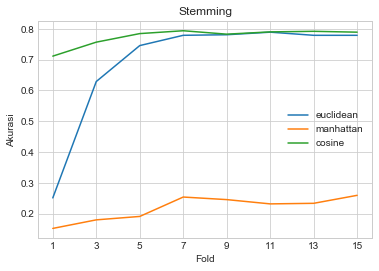

Tanpa Stemming
Nama distance= euclidean
Jumlah K tetangga= 1
Fold ke- 1 Akurasi = 0.1019 Precision = 0.6950 Recall = 0.1019 F1-Score = 0.1855
Fold ke- 2 Akurasi = 0.1204 Precision = 0.8173 Recall = 0.1204 F1-Score = 0.1919
Fold ke- 3 Akurasi = 0.6111 Precision = 0.6376 Recall = 0.6111 F1-Score = 0.6007
Fold ke- 4 Akurasi = 0.1852 Precision = 0.8617 Recall = 0.1852 F1-Score = 0.2633
Fold ke- 5 Akurasi = 0.2222 Precision = 0.8456 Recall = 0.2222 F1-Score = 0.3477
Fold ke- 6 Akurasi = 0.2593 Precision = 0.8716 Recall = 0.2593 F1-Score = 0.4518
Fold ke- 7 Akurasi = 0.2315 Precision = 0.8525 Recall = 0.2315 F1-Score = 0.3194
Fold ke- 8 Akurasi = 0.1944 Precision = 0.7596 Recall = 0.1944 F1-Score = 0.2384
Fold ke- 9 Akurasi = 0.1944 Precision = 0.7278 Recall = 0.1944 F1-Score = 0.3073
Fold ke- 10 Akurasi = 0.1944 Precision = 0.8036 Recall = 0.1944 F1-Score = 0.2855
Avg accuracy = 0.2315 Avg precision= 0.7872 Avg recall= 0.2315 Avg f1 Score= 0.3191
Akurasi terbaik adalah 0.6111111111111112 pa

Fold ke- 1 Akurasi = 0.0926 Precision = 0.5421 Recall = 0.0926 F1-Score = 0.1776
Fold ke- 2 Akurasi = 0.1019 Precision = 0.6950 Recall = 0.1019 F1-Score = 0.1855
Fold ke- 3 Akurasi = 0.1296 Precision = 0.7269 Recall = 0.1296 F1-Score = 0.1660
Fold ke- 4 Akurasi = 0.1204 Precision = 0.8173 Recall = 0.1204 F1-Score = 0.1919
Fold ke- 5 Akurasi = 0.1574 Precision = 0.8483 Recall = 0.1574 F1-Score = 0.2760
Fold ke- 6 Akurasi = 0.2037 Precision = 0.8491 Recall = 0.2037 F1-Score = 0.3812
Fold ke- 7 Akurasi = 0.1759 Precision = 0.8241 Recall = 0.1759 F1-Score = 0.2553
Fold ke- 8 Akurasi = 0.1667 Precision = 0.8864 Recall = 0.1667 F1-Score = 0.2367
Fold ke- 9 Akurasi = 0.1389 Precision = 0.8480 Recall = 0.1389 F1-Score = 0.2210
Fold ke- 10 Akurasi = 0.1389 Precision = 0.6817 Recall = 0.1389 F1-Score = 0.2154
Avg accuracy = 0.1426 Avg precision= 0.7719 Avg recall= 0.1426 Avg f1 Score= 0.2307
Akurasi terbaik adalah 0.2037037037037037 pada fold ke- 6
------------------------------------
Tanpa Stem

Fold ke- 2 Akurasi = 0.7037 Precision = 0.7147 Recall = 0.7037 F1-Score = 0.6994
Fold ke- 3 Akurasi = 0.6111 Precision = 0.6381 Recall = 0.6111 F1-Score = 0.6027
Fold ke- 4 Akurasi = 0.7037 Precision = 0.7514 Recall = 0.7037 F1-Score = 0.7023
Fold ke- 5 Akurasi = 0.7593 Precision = 0.7673 Recall = 0.7593 F1-Score = 0.7571
Fold ke- 6 Akurasi = 0.8426 Precision = 0.8607 Recall = 0.8426 F1-Score = 0.8409
Fold ke- 7 Akurasi = 0.8148 Precision = 0.8354 Recall = 0.8148 F1-Score = 0.8064
Fold ke- 8 Akurasi = 0.7500 Precision = 0.7429 Recall = 0.7500 F1-Score = 0.7338
Fold ke- 9 Akurasi = 0.7500 Precision = 0.7650 Recall = 0.7500 F1-Score = 0.7445
Fold ke- 10 Akurasi = 0.7315 Precision = 0.7687 Recall = 0.7315 F1-Score = 0.7220
Avg accuracy = 0.7296 Avg precision= 0.7483 Avg recall= 0.7296 Avg f1 Score= 0.7228
Akurasi terbaik adalah 0.8425925925925926 pada fold ke- 6
------------------------------------
Tanpa Stemming
Nama distance= cosine
Jumlah K tetangga= 3
Fold ke- 1 Akurasi = 0.7130 Preci

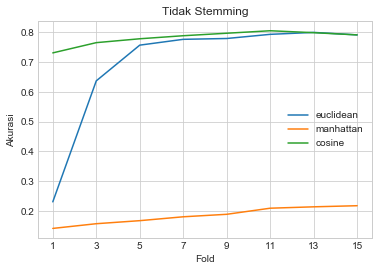

Lama Proses 161.3739674091339 seconds
Wall time: 2min 41s


In [12]:
%%time
start_time = time.time()
dfcount = [df,dfNo]
distancecount = ['euclidean','manhattan','cosine']
kcount = [1,3,5,7,9,11,13,15]
for x in range(2):
    arrd1 = []
    arrd2 = []
    arrd3 = []
    for y in range(len(distancecount)):
        maxresult = []
        for z in range(len(kcount)):
            if x==0:
                print('Dengan Stemming')
            else:
                print('Tanpa Stemming')
            tempmax= classifier(dfcount[x],distancecount[y],kcount[z])
            maxresult.append(tempmax)
            if y==0:
                arrd1.append(tempmax)
            elif y==1:
                arrd2.append(tempmax)
            elif y==2:
                arrd3.append(tempmax)
    plt.plot(kcount, arrd1, label = "euclidean")
    plt.plot(kcount, arrd2, label = "manhattan")
    plt.plot(kcount, arrd3, label = "cosine")
    plt.xticks(kcount)
    if x==0:
        plt.title("Stemming")
    else:
        plt.title("Tidak Stemming")
    plt.xlabel('Fold')
    plt.ylabel('Akurasi')
    plt.legend()
    plt.pause(0.05)
plt.show
plt.style.use('seaborn-whitegrid')
print("Lama Proses %s seconds" % (time.time() - start_time))